In [1]:
import requests
import pandas as pd

# Replace these variables with your specific parameters
base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
parameters = {
    "parameters": "ALLSKY_SFC_SW_DWN",
    "start": "20240707",
    "end": "20240713",
    "latitude": 30.9529,
    "longitude": -103.3617,
    "format": "JSON",
    "community": "re",
}

# Step 1: Fetch data from NASA POWER API
response = requests.get(base_url, params=parameters)
data = response.json()

# Step 2: Parse the data
timestamps = list(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"].keys())
irradiance_values = list(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"].values())

# Step 3: Create a DataFrame
solar_data = {
    "Datetime": pd.to_datetime(timestamps, format="%Y%m%d%H"),  # Convert strings to datetime
    "Solar_Irradiance": irradiance_values,
}
solar_df = pd.DataFrame(solar_data)

# Step 4: Calculate Availability
solar_df["Availability"] = solar_df["Solar_Irradiance"] / max(solar_df["Solar_Irradiance"])

# Step 5: Configure display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 6: Display the DataFrame
print(solar_df)

# Step 7: (Optional) Save to a CSV file
solar_df.to_csv("solar_data_final.csv", index=False)


/Users/skyegoodman/Documents/OPTIMISING POWER GRIDS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


               Datetime  Solar_Irradiance  Availability
0   2024-07-07 00:00:00              0.00      0.000000
1   2024-07-07 01:00:00              0.00      0.000000
2   2024-07-07 02:00:00              0.00      0.000000
3   2024-07-07 03:00:00              0.00      0.000000
4   2024-07-07 04:00:00              0.00      0.000000
5   2024-07-07 05:00:00             52.53      0.051933
6   2024-07-07 06:00:00            247.25      0.244439
7   2024-07-07 07:00:00            460.20      0.454968
8   2024-07-07 08:00:00            665.08      0.657519
9   2024-07-07 09:00:00            841.60      0.832032
10  2024-07-07 10:00:00            965.15      0.954177
11  2024-07-07 11:00:00            999.65      0.988285
12  2024-07-07 12:00:00            935.35      0.924716
13  2024-07-07 13:00:00            724.05      0.715818
14  2024-07-07 14:00:00            731.17      0.722857
15  2024-07-07 15:00:00            516.12      0.510252
16  2024-07-07 16:00:00            376.50      0

In [2]:
# SOLVER WITH JUST WIND AND SOLAR PROFILES BUT NO RAMPING 
import pandas as pd
import numpy as np
import cvxpy as cp  # used for convex optimisation problems, like this one

#-------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)  # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)  # Have LINE_ID as row index of the dataframe
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)  # 532x1 vector

#-------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}  # indices of generators in node_IDs
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))  # (428,5)
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1  # Mark each generator for each column as a 1

# Demand contributions
demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}  # indices of demands in node_IDs
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))  # (428,20)
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1  # Mark each demand node for each column as a 1

#-------------------------------------------------------------------------------------------------------
# HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
# Load solar irradiance data (output from NASA POWER API processing)
solar_data = pd.read_csv("solar_data_final.csv")
solar_availability = solar_data["Availability"].values  # Use raw availability values from the data

# Generate Weibull-distributed wind availability
hours = node_demands.shape[0]
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability = np.random.weibull(shape, hours) * scale
wind_availability = np.clip(wind_availability, 0.4, 1.0)  # Ensure at least 40% availability

# Create the availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = solar_availability  # Generator 1 (solar)
availability_matrix[1, :] = wind_availability  # Generator 2 (wind)

#-------------------------------------------------------------------------------------------------------
# CALCULATE EFFECTIVE CAPACITY FOR DEBUGGING
effective_capacity = gen_capacities[:, None] * availability_matrix

# Debugging: Print effective capacities for the first two generators
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

#-------------------------------------------------------------------------------------------------------
# DECISION VARIABLES: q_supply - the power supply from each of the 5 generators for each hour (5x168)
q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

#-------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# # (1) - Total hourly generation must equal the total hourly demand (as assuming no power loss/ have a perfect network)
# constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))  # axis=0 goes through columns (each hour)

# # (2) - Line flow constraints (with maximal power ratings)
# net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T  # (428x168)
# PF = shift_factor_matrix.values @ net_injections

# finite_mask = np.isfinite(line_ratings.values.flatten())
# constraints += [
#     PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
#     PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None]
# ]

# # (3) - Generator capacity constraints with hourly availability
# constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]  # Apply availability to capacities
# (1) - Total hourly generation must equal the total hourly demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# (2) - Line flow constraints (with maximal power ratings)
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T  # (428x168)
PF = shift_factor_matrix.values @ net_injections

finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None]
]

# (3) - Generator capacity constraints with hourly availability
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]  # Apply availability to capacities

# (4) - Ensure remaining demand is met by Generators 3, 4, and 5
# Calculate the remaining demand after Generators 1 and 2 (solar and wind)
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)

# Ensure generators 3, 4, and 5 meet the remaining demand
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# (5) - Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]  # Their full capacity


#-------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)  # 5 generator rows by 168 hour columns

# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
    print("Optimal generator dispatch (MW):")
    print(q_supply_table)
else:
    print("NO OPTIMAL SOLUTION FOUND!")


Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          16.98961938  84

In [3]:
print("Availability Matrix:")
print(availability_matrix)

Availability Matrix:
[[0.         0.         0.         0.         0.         0.05193277
  0.24443895 0.45496787 0.65751854 0.83203164 0.95417696 0.98828473
  0.92471577 0.71581809 0.72285714 0.5102521  0.37221948 0.20471577
  0.03794365 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04391498
  0.22251112 0.41193277 0.55541275 0.63017301 0.65394958 0.70074147
  0.64639644 0.62160158 0.71209095 0.58024716 0.40906574 0.20685121
  0.02706871 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.0405042
  0.22542758 0.43921898 0.63450321 0.80441918 0.90044488 0.86895699
  0.83010381 0.79649036 0.6788433  0.5228868  0.38233317 0.23064755
  0.0397133  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04854177
  0.2402175  0.45684627 0.65983193 0.82778052 0.94516065 0.97792388
  0.95709343 0.88584281 0.76930302 0.57076619 0.3782

In [4]:
effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          16.98961938  84

In [5]:
total_demand = np.sum(node_demands.values.T, axis=0)  # Sum across nodes for each hour
total_available_capacity = np.sum(effective_capacity, axis=0)  # Total available capacity each hour

print("Hour | Total Demand | Total Available Capacity")
for hour in range(len(total_demand)):
    print(f"{hour+1:4} | {total_demand[hour]:12.2f} | {total_available_capacity[hour]:25.2f}")


Hour | Total Demand | Total Available Capacity
   1 |       468.93 |                   1100.00
   2 |       605.96 |                    926.59
   3 |       595.61 |                   1100.00
   4 |       592.07 |                    890.00
   5 |       599.63 |                    890.00
   6 |       620.28 |                    908.18
   7 |       644.29 |                   1146.86
   8 |       662.50 |                   1180.09
   9 |       688.22 |                   1330.13
  10 |       726.99 |                   1228.12
  11 |       763.65 |                   1223.96
  12 |       780.28 |                   1235.90
  13 |       773.56 |                   1213.65
  14 |       762.20 |                   1350.54
  15 |       753.62 |                   1143.00
  16 |       747.67 |                   1225.04
  17 |       769.87 |                   1198.14
  18 |       830.97 |                   1171.65
  19 |       872.48 |                   1113.28
  20 |       871.62 |                   1

In [6]:
print("Hour | Effective Capacity (Solar) | Dispatch (Solar)")
for hour in range(availability_matrix.shape[1]):
    print(f"{hour+1:4} | {effective_capacity[0, hour]:25.2f} | {q_supply.value[0, hour]:10.2f}")

Hour | Effective Capacity (Solar) | Dispatch (Solar)


TypeError: 'NoneType' object is not subscriptable

Ramp rates (MW/hour): {3: array([14.99991163]), 4: array([9.99938364]), 5: array([50.00747873])}
Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0

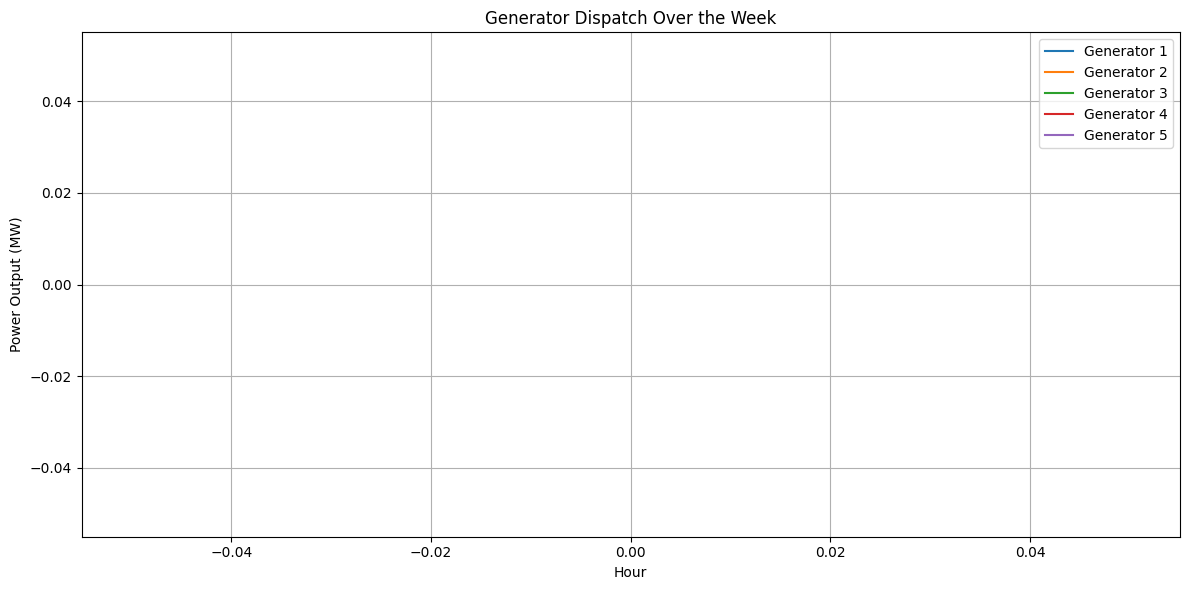

In [7]:
# SOLVER WITH WIND, SOLAR AND RAMPING CONSTRAINTS
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)  # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)  # PTDF matrix
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)  # Line ratings
# -------------------------------------------------------------------------------------------------------

# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SOLVE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    """
    Simulates a generator's ramping response using a delay differential equation (DDE).
    Args:
        tau: Time constant for the generator.
        delay: Time delay before response begins.
        P_initial: Initial power output (MW).
        P_target: Target power output (MW).
        duration: Total simulation time (hours).
        steps: Number of time steps for simulation.
    Returns:
        ramp_rate: Approximate ramp rate (MW/hour).
    """
    time = np.linspace(0, duration, steps)

    # Define the DDE model
    def model(P, t):
        return (P_target - P(t - delay)) / tau

    # Define the history function
    def history(t):
        return P_initial

    # Solve the DDE
    response = ddeint(model, history, time)

    # Approximate ramp rate as the slope over the simulation period
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)  # Return the absolute value of ramp rate

# Determine ramp rates for generators 3, 4, and 5
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
# Load solar irradiance data (output from NASA POWER API processing)
solar_data = pd.read_csv("solar_data_final.csv")
solar_availability = solar_data["Availability"].values  # Use raw availability values from the data

# Generate Weibull-distributed wind availability
hours = node_demands.shape[0]
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability = np.random.weibull(shape, hours) * scale
wind_availability = np.clip(wind_availability, 0.4, 1.0)  # Ensure at least 40% availability

# Create the availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = solar_availability  # Generator 1 (solar)
availability_matrix[1, :] = wind_availability  # Generator 2 (wind)

# -------------------------------------------------------------------------------------------------------
# CALCULATE EFFECTIVE CAPACITY FOR DEBUGGING
effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES: q_supply - power supply from each generator for each hour (5x168)
q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# (1) - Total hourly generation must equal the total hourly demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# (2) - Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections

finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# (3) - Generator capacity constraints with hourly availability
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# (4) - Ensure remaining demand is met by Generators 3, 4, and 5
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# (5) - Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# (6) - Ramping constraints for Generators 3, 4, and 5
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1  # Adjust for zero-based indexing
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT THE DISPATCH FROM GENERATORS OVER THE WEEK
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Debugging Effective Capacity and Remaining Demand
effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

# Remaining Demand
remaining_demand_values = (
    np.sum(node_demands.values.T, axis=0)
    - (np.sum(q_supply[:2, :].value, axis=0) if q_supply.value is not None else np.zeros(hours))
)
print("Remaining Demand (per hour):", remaining_demand_values)

# Check Total Supply vs. Demand
total_available_capacity = np.sum(effective_capacity, axis=0)
total_demand = np.sum(node_demands.values.T, axis=0)
print("Total Available Capacity (per hour):", total_available_capacity)
print("Total Demand (per hour):", total_demand)

Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          16.98961938  84